# **NEURAL NETWORKS AND DEEP LEARNING COURSEWORK ASSIGNMENT SEMESTER B 2023**

# **IMAGE CLASSIFICATION OF CIFAR-10 DATASET USING CONVOLUTIONAL NEURAL NETWORK TO CLASSIFY THE EVERY IMAGE IN TERMS OF 1 OUT OF 10 CLASSES**

In [ ]:
#Importing all the neccessary libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
import time
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
import random


**1. Read the dataset and create loadbalancers**

Here, we define and apply data transformations to preprocess the CIFAR-10 dataset for training and testing by using RandomCrop and RandomHorizontalFlip which transforms randomly crop and flip the images during training to increase the size and diversity of the dataset, which can help improve the model's performance and reduce overfitting. We then download and load the preprocessed datasets using PyTorch's DataLoader class for efficient batch processing during model training and testing.

In [ ]:
# Define the transformation for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #Randomly crop images with a padding of 4 pixels 
    transforms.RandomHorizontalFlip(), #Randomly flip images horizontally
    transforms.ToTensor(),         # convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize pixel values with mean and std dev values of 0.5 for each RGB channel
])

# Define the transformation for the test set
transform_test = transforms.Compose([
    transforms.ToTensor(), # convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize pixel values with mean and std dev values of 0.5 for each RGB channel
])

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


**Visualising a random set of samples from the dataset:**

In the code below, we are visualizing a random set of 10 images and their corresponding labels from the CIFAR-10 dataset, after de-normalizing, clipping, and transposing the images. It uses matplotlib to create a grid of subplots, where each subplot displays an image with its label as the title.

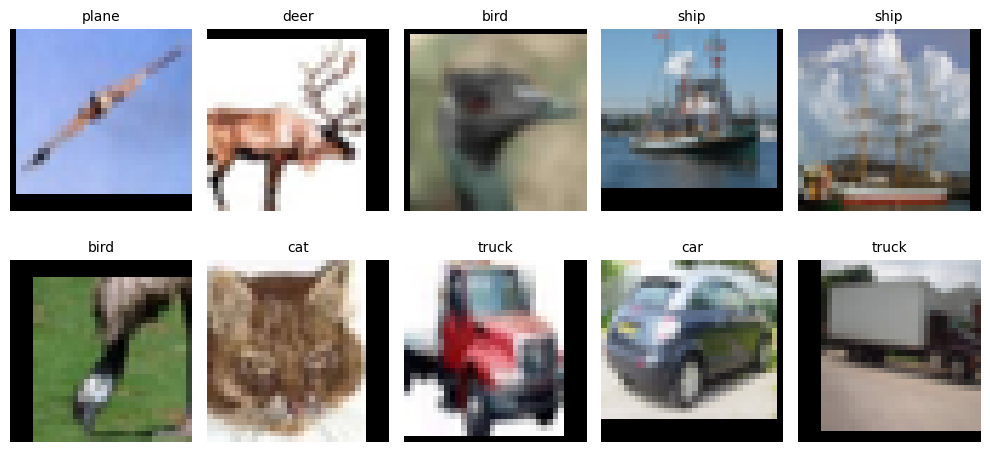

In [ ]:
#We are visualizing a random set of samples from the dataset
# Define the classes for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get a batch of images and labels from the trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Randomly select 10 images from the batch
indices = np.random.choice(range(len(images)), size=10, replace=False)
images = images[indices]
labels = labels[indices]

# De-normalize the images to reverse the normalization applied during data preprocessing
images = (images * 0.5) + 0.5

# Clip the pixel values to be within the range [0, 1]
images = np.clip(images, 0, 1)

# Transpose the images to be in the format (height, width, channels) for display
images = np.transpose(images, (0, 2, 3, 1))

# Create a grid of subplots with 2 rows and 5 columns to display 10 images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

# Loop through each subplot and plot the corresponding image and label
for i, ax in enumerate(axes.flat):
    # Plot the image in the current subplot
    ax.imshow(images[i])
    
    # Get the label of the image
    label = classes[labels[i]]
    
    # Set the title of the subplot as the image label
    ax.set_title(label, fontsize=10)
    # Remove axis markings
    ax.axis('off')

# Show the plot with the grid of images
plt.tight_layout()
plt.show()


**2. Create a Model:**

The problem statement is to build a model for the Cifar-10 dataset using backbone and classifier where the backbone should consists of N blocks. The basic (minimum) implementation of each block consists of : 1 linear/MLP Layer predicting a vector a = [a1,.... ak] with k elements  from input tensor X: a = g(SpatialAveragePool(X)W where g is a non-linear activation function. SpatialAveragePool(X) calculates the spatial average per channel returning a vector of d channels. K convolutional layers which are combined using a to produce a single output

O=a1 Conv1 (X) +...+ak Convk(X). 

Then, the classifier should take the input the output of the last block and should compute a mean feature f = SpatialAveragePool (On), where On here is the output of the nth block. It passes f to a classifier can be a softmax regression classifier or an MLP.

**In the below code, we have defined two classes "Block" and "Model"**

1.   The Block class is a building block for the CIFAR 10 dataset that is used in the Model class. It is a custom convolutional block that uses adaptive convolutions with channel-wise weights to improve the performance of the convolutional neural network. The block consists of two convolutional layers, each followed by batch normalization and rectified linear unit (ReLU) activation function. It also has a residual connection to bypass the block, and it can handle the cases where the input and output channels are different using the residual connection.
2.   Model defines a convolutional neural network (CNN) model for image classification on the CIFAR-10 dataset. The model consists of a backbone, which is a sequence of Block instances and other layers like convolutional layers and max pooling layers, and a classifier, which is a series of fully connected layers that produce the final class scores. The model takes an input image, passes it through the backbone, and produces the class scores using the classifier.



In [ ]:
# Defining a Block class to represent a building block for the CIFAR 10 dataset 
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
        # Spatial average pooling to reduce the spatial dimensions to 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer to obtain channel-wise weights for adaptive convolutions
        self.fc = nn.Linear(in_channels, k)
        
        # Convolutional layers 
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        # BatchNorm layers 
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Residual connection
        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Residual connection weights initialization
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        # CalculatING the channel-wise weights using the fully connected layer
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Performing the adaptive convolutions with the calculated weights
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = a[:, 0:1] * out

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = a[:, 1:2] * out

        # Add the residual connection to the output
        res = self.residual(x)
        out += res
        return out

# Defining the  Model class
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Defining the backbone of the model as a sequence of blocks and other layers
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # convolutional layer with 3 input channels, 64 output channels, kernel size of 3, and padding of 1
            nn.BatchNorm2d(64), # batch normalization with 64 output channels
            nn.ReLU(inplace=True), # rectified linear unit (ReLU) activation function
            Block(64, 64), # use the Block class to create a block with 64 input and output channels
            nn.MaxPool2d(2, 2), # max pooling layer with kernel size of 2 and stride of 2
            Block(64, 128), # use the Block class to create a block with 64 input and 128 output channels
            nn.MaxPool2d(2, 2), # max pooling layer with kernel size of 2 and stride of 2
            Block(128, 256), # use the Block class to create a block with 128 input and 256 output channels
            nn.MaxPool2d(2, 2), # max pooling layer with kernel size of 2 and stride of 2
            Block(256, 512), # use the Block class to create a block with 256 input and 512 output channels
            nn.MaxPool2d(2, 2) # max pooling layer with kernel size of 2 and stride of 2
        )

        self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),  # Reducing the spatial dimensions to 1x1
        nn.Flatten(),                 # Flattening the tensor into a 1D vector
        nn.Linear(512, 10)            # Fully connected layer to produce the final class scores
    )

  # Define the forward pass of the model
    def forward(self, x):
      x = self.backbone(x)          # Pass the input through the backbone
      x = self.classifier(x)        # Pass the output of the backbone through the classifier
      return x


In [ ]:
#Creating an instance of the Model 
model = Model()

**3. Create a loss and optimizer**

Here, we are making use of Focal Loss technique by creating a custom loss function by defining an instance of the custom loss function with specific hyperparameters and defining an optimizer using Adam algorithm, and defining a learning rate scheduler using Cosine Annealing LR with specific hyperparameters. The custom loss function uses log probabilities and probabilities of the input tensor, one-hot target tensor, and focal weight to calculate the focal loss. The optimizer updates the parameters of the model during training, and the learning rate scheduler adjusts the learning rate of the optimizer over epochs.

The use of Focal Loss technique here is efficient because it helps to reduce the effect of class imbalance and produce better results for the minority class. The hard examples are given more importance, which can help the model learn better features and reduce the effect of noisy or irrelevant features.

In [ ]:
# Set the device to use (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the custom loss function using Focal Loss technique
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        # Calculate the log probabilities of the input tensor using log_softmax
        log_prob = F.log_softmax(input, dim=-1)

        # Calculate the probabilities of the input tensor using softmax
        prob = F.softmax(input, dim=-1)

        # Create a one-hot target tensor
        target_onehot = F.one_hot(target, num_classes=input.shape[-1]).float()

        # Calculate the focal weight for each element in the input tensor
        weight = torch.pow(1 - prob, self.gamma)

        # Apply the alpha weighting to the target tensor
        if self.alpha is not None:
            alpha_weight = torch.ones_like(target_onehot)
            alpha_weight[target_onehot == 1] = self.alpha
            alpha_weight[target_onehot == 0] = 1 - self.alpha
            target_onehot *= alpha_weight

        # Calculate the focal loss by multiplying the focal weight and one-hot target tensors with
        # the log probabilities, summing along the class dimension, and then taking the mean value
        focal_loss = (-weight * target_onehot * log_prob).sum(dim=-1).mean()

        return focal_loss

# Create an instance of the custom loss function with gamma=2 and alpha=0.5
criterion = FocalLoss(gamma=2, alpha=0.5)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)


**Creating a class for training and validating the Cifar-10 dataset**

1.   The train_epoch function performs one epoch of training on a given model using a given dataloader. It sets the model to training mode, moves the data and the model to the device, and loops through the mini-batches of data. It performs the forward pass, calculates the loss using the given criterion, scales and accumulates the gradients using mixed-precision training with the GradScaler object, updates the model parameters every 'accumulation_steps' mini-batches, accumulates the loss, and calculates the accuracy. Finally, it returns the average loss and accuracy for the epoch.

2.   The validate_epoch function performs one epoch of validation on a given model using a given dataloader. It sets the model to evaluation mode, moves the data and the model to the device, and loops through the mini-batches of data. It performs the forward pass, calculates the loss using the given criterion, accumulates the loss, and counts the number of correct predictions. Finally, it returns the average loss and accuracy for the epoch. Unlike the train_epoch function, it does not perform any gradient updates, and it disables gradient calculation and graph building using the torch.no_grad() context manager to save memory.


In [ ]:
#Defining the training class to train the mode;
def train_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model.to(device)  # Move the model to the device
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    scaler = GradScaler() # Create a GradScaler object to perform mixed precision training
    optimizer.zero_grad()  # Reset gradients outside the loop
  
    # Loop through the training data (images and labels)
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device

        # Perform forward pass and loss calculation inside autocast context to perform mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()  # Scale and accumulate gradients

        # Update model parameters after accumulating gradients for 'accumulation_steps' mini-batches
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)  # Update the model parameters with scaled gradients
            scaler.update() # Update the GradScaler object
            optimizer.zero_grad()  # Reset the gradients

        running_loss += loss.item() * images.size(0)  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        total += labels.size(0)  # Update the total number of samples
        correct += predicted.eq(labels).sum().item()  # Count the number of correct predictions
    
    # If there are remaining gradients to accumulate, do it now
    if (i + 1) % accumulation_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss for the epoch
    epoch_accuracy = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_accuracy

#Defining the validation class to validate the model
def validate_epoch(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation and graph building
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss

            running_loss += loss.item() * inputs.size(0)  # Accumulate the loss
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()  # Count the number of correct predictions
            total += labels.size(0)  # Update the total number of samples

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss for the epoch
    epoch_accuracy = correct / total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_accuracy


**4. Write training scripts to train the model**

Here, we are training the mode. We first set the random seed for reproducibility and define the data loaders for training and validation. Then, we train the model using a specified number of epochs, calculate the loss and accuracy at each epoch, and update the learning rate scheduler. 

In [ ]:
# Set random seed for reproducibility
seed = 10
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Define the number of workers for data loading
num_workers = 2

# Define the data loaders for training and validation
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Training parameters
num_epochs = 50
print_every = 5

# Store the loss and accuracy entries
train_loss_entries = [] # list to store the training loss at each epoch
val_loss_entries = [] # list to store the validation loss at each epoch
train_acc_entries = [] # list to store the training accuracy at each epoch
val_acc_entries = [] # list to store the validation accuracy at each epoch

# record the start time of training
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # initialize the running loss to zero
    correct = 0  # initialize the number of correct predictions to zero
    total = 0  # initialize the total number of predictions to zero
    
    # loop over each batch in the training set
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)   # move the images and labels to the GPU if available

        optimizer.zero_grad() # set the gradients to zero

        outputs = model(images) # forward pass through the model
        loss = criterion(outputs, labels) # calculate the loss
        loss.backward() # backward pass to calculate the gradients

        optimizer.step() # update the parameters

        running_loss += loss.item() * images.size(0) # accumulate the running loss
        _, predicted = torch.max(outputs.data, 1) # get the predicted classes
        total += labels.size(0) # increment the total number of predictions
        correct += (predicted == labels).sum().item() # increment the number of correct predictions

    train_loss = running_loss / len(trainloader.dataset) # calculate the average training loss
    train_accuracy = correct / len(trainloader.dataset) # calculate the training accuracy

    model.eval() # set the model to evaluation mode
    running_loss = 0.0 # initialize the running loss to zero
    correct = 0 # initialize the number of correct predictions to zero
    total = 0 # initialize the total number of predictions to zero

    with torch.no_grad(): # turn off gradient calculations
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device) # move the images and labels to the GPU if available

            outputs = model(images)  # forward pass through the model
            loss = criterion(outputs, labels) # calculate the loss
 
            running_loss += loss.item() * images.size(0)  # accumulate the running loss
            _, predicted = torch.max(outputs.data, 1) # get the predicted classes
            total += labels.size(0) # increment the total number of predictions
            correct += (predicted == labels).sum().item()  # increment the number of correct predictions

    val_loss = running_loss / len(testloader.dataset) #obtaining the validation loss
    val_accuracy = correct / len(testloader.dataset) ##obtaining the validation accuracy

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    #Appending the train and validation loss and accuracy details to the list intially created
    train_loss_entries.append(train_loss)
    val_loss_entries.append(val_loss)
    train_acc_entries.append(train_accuracy)
    val_acc_entries.append(val_accuracy)

    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

#Recording the end time of training
end_time = time.time()

print(f'Training finished in {(end_time - start_time):.2f} seconds.')

# Calculate average loss and accuracy over all epochs
avg_train_loss = sum(train_loss_entries) / len(train_loss_entries)
avg_val_loss = sum(val_loss_entries) / len(val_loss_entries)
avg_train_acc = sum(train_acc_entries) / len(train_acc_entries)
avg_val_acc = sum(val_acc_entries) / len(val_acc_entries)

print(f'Average Train Loss: {avg_train_loss:.4f}, Average Train Acc: {avg_train_acc:.4f}, Average Val Loss: {avg_val_loss:.4f}, Average Val Acc: {avg_val_acc:.4f}')


Epoch [5/50], Train Loss: 0.1613, Train Acc: 0.7938, Val Loss: 0.1979, Val Acc: 0.7680
Epoch [10/50], Train Loss: 0.1042, Train Acc: 0.8582, Val Loss: 0.1246, Val Acc: 0.8385
Epoch [15/50], Train Loss: 0.0769, Train Acc: 0.8904, Val Loss: 0.1209, Val Acc: 0.8516
Epoch [20/50], Train Loss: 0.0617, Train Acc: 0.9074, Val Loss: 0.1068, Val Acc: 0.8642
Epoch [25/50], Train Loss: 0.0512, Train Acc: 0.9218, Val Loss: 0.0971, Val Acc: 0.8814
Epoch [30/50], Train Loss: 0.0427, Train Acc: 0.9325, Val Loss: 0.0930, Val Acc: 0.8901
Epoch [35/50], Train Loss: 0.0359, Train Acc: 0.9423, Val Loss: 0.0842, Val Acc: 0.8958
Epoch [40/50], Train Loss: 0.0305, Train Acc: 0.9485, Val Loss: 0.0955, Val Acc: 0.8918
Epoch [45/50], Train Loss: 0.0254, Train Acc: 0.9564, Val Loss: 0.0862, Val Acc: 0.9007
Epoch [50/50], Train Loss: 0.0203, Train Acc: 0.9645, Val Loss: 0.0869, Val Acc: 0.9017
Training finished in 2106.94 seconds.
Average Train Loss: 0.0751, Average Train Acc: 0.8959, Average Val Loss: 0.1157, Av

Finally, we plot the loss and accuracy curves for both training and validation data. The purpose of this code is to train and evaluate the performance of the model on the given dataset.

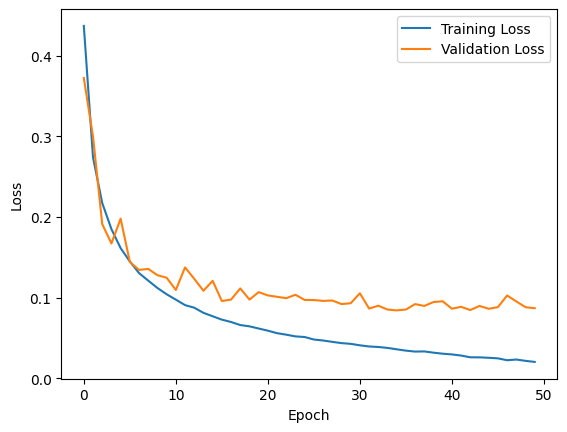

In [ ]:
# Plotting the loss curve
plt.figure()
plt.plot(train_loss_entries, label='Training Loss')
plt.plot(val_loss_entries, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


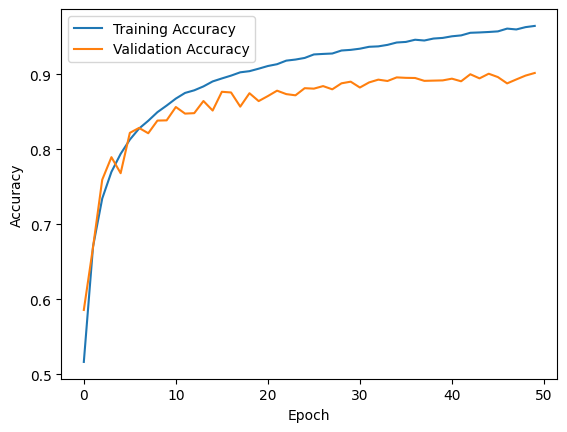

In [ ]:
# Plotting the accuracy curve
plt.figure()
plt.plot(train_acc_entries, label='Training Accuracy')
plt.plot(val_acc_entries, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Visualizing Predictions on a Random Subset of Validation Data**

Here, we are visualizing a random subset of the validation set with their predicted and actual labels. First, we set the model to evaluation mode and create empty lists to store the predictions and actual labels. Then, we loop through the validation data and collect the predicted labels and actual labels. Next, we concatenate the list of predictions and actual labels into a tensor. After that, we select a random subset of the validation set and extract the predicted labels, actual labels, and corresponding images. Finally, we visualize the random subset with their predicted and actual labels using matplotlib. The predicted labels are shown in blue if they match the actual labels and red if they do not.

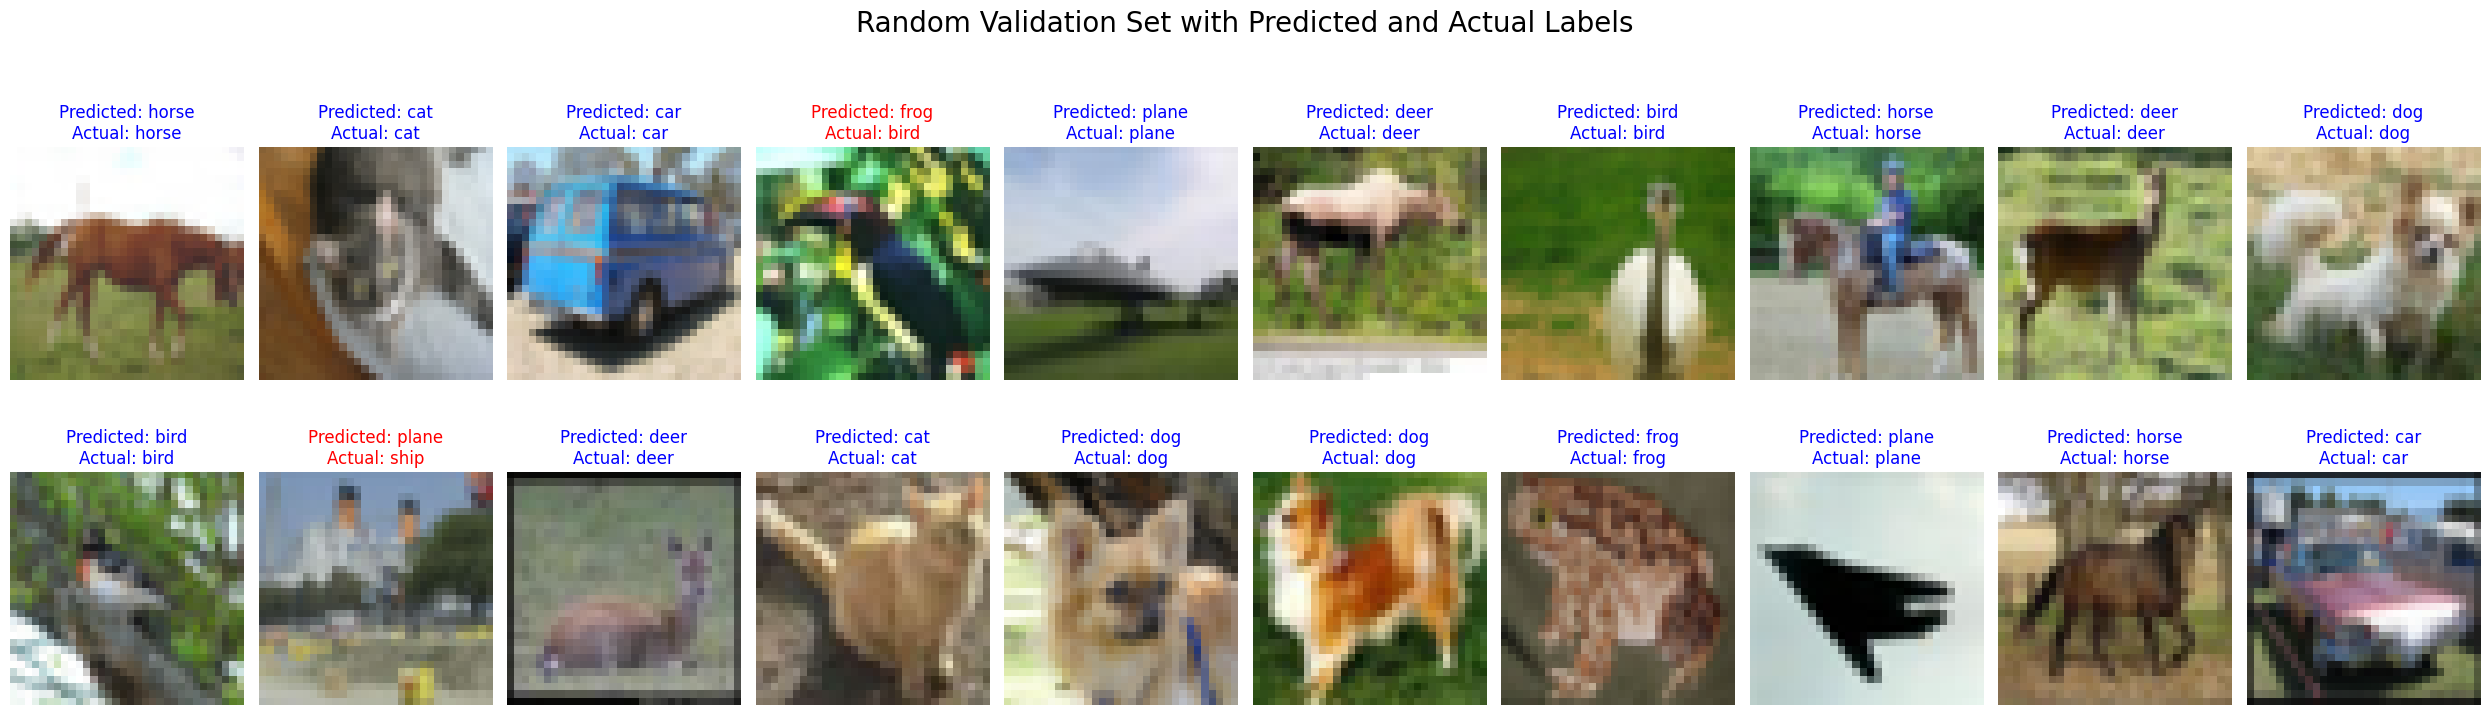

In [ ]:
# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predictions and actual labels
predicted_label = []
target_label = []

# Loop through the validation data and collect predictions and actual labels
with torch.no_grad():  # temporarily turn off gradient computation during inference to save memory
    for images, labels in testloader: # iterate through the test dataset
        images, labels = images.to(device), labels.to(device) # move data to GPU if available
        outputs = model(images) # forward pass through the model to get the output logits
        _, predicted = torch.max(outputs.data, 1) # get the predicted class for each input image
        predicted_label.append(predicted.cpu()) # store predicted class labels on CPU
        target_label.append(labels.cpu()) # store actual class labels on CPU

# Concatenate the list of predictions and actual labels into a tensor
pred = torch.cat(predicted_label)
target = torch.cat(target_label)

# Select a random subset of the validation set
indices = np.random.choice(len(target), size=20, replace=False)

# get the predicted and target class labels for the selected indices and convert to numpy array
subset_preds = pred[indices].numpy()
subset_targets = target[indices].numpy()
subset_images = testset.data[indices] # get the input images for the selected indices

# Visualize the random subset with predicted and actual labels
fig, axs = plt.subplots(2, 10, figsize=(25, 8))
fig.suptitle("Random Validation Set with Predicted and Actual Labels", fontsize=20)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(subset_images[i])
    ax.set_title(f"Predicted: {classes[subset_preds[i]]}\nActual: {classes[subset_targets[i]]}", color=("blue" if subset_preds[i]==subset_targets[i] else "red"), fontsize=12)
    ax.axis("off")
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.show()


**Conclusion**

*   The final training loss is 0.0203 and the final training accuracy is    **96.45%**. This indicates that the model has achieved good performance on the training set.
*   The final validation loss is 0.0869, and the final validation accuracy is **90.17%**. This indicates that the model has achieved good performance on the validation set as well.
*   The average training loss across all epochs is 0.0751 and the average training accuracy is **89.59%**. The average validation loss is 0.1157 and the average validation accuracy is **86.01%**. These values indicate that the model was able to maintain good performance on both the training and validation sets throughout the training process without overfitting or underfitting.

In summary, the provided values suggest that the model has achieved good performance on both the training and validation sets and that it was trained for a sufficient number of epochs without overfitting.













# **REFERENCES**

Please, find below the references used for performing data augmentation, spatial average pooling, model architecture, focal loss optimization and training and validating the model.

*   https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html
*   https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
*   https://towardsdatascience.com/using-convolutional-neural-network-for-image-classification-5997bfd0ede4
*   https://medium.com/mlearning-ai/cifar10-image-classification-in-pytorch-e5185176fbef
*   https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch
*   https://towardsdatascience.com/building-a-residual-network-with-pytorch-df2f6937053b
*   https://medium.com/@sergioalves94/deep-learning-in-pytorch-with-cifar-10-dataset-858b504a6b54
*   https://blog.demir.io/understanding-image-classification-data-augmentation-and-residual-networks-fd40615e1d4
*   https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
*   https://www.analyticsvidhya.com/blog/2021/09/convolutional-neural-network-pytorch-implementation-on-cifar10-dataset/








